In [175]:
import numpy as np
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

In [176]:
filename = 'HIV-TB Coinfection'

In [177]:
def parse_compartment(line):
  return line.replace('[', '').replace(']', '').replace('\n', '').split(', ')

In [178]:
compartments = [parse_compartment(line) for line in open(f'{filename}.compartments.txt').readlines()]
_flows = open(f'{filename}.equations.txt').readlines()
number_of_lines_per_flow_in_file = 6
number_of_flows = int(len(_flows) / number_of_lines_per_flow_in_file)
flows = [_flows[i * number_of_lines_per_flow_in_file:(i + 1) * number_of_lines_per_flow_in_file] for i in range(number_of_flows)]

In [179]:
modelsize = len(compartments)
modelsize, compartments[0]

(256,
 ['Age',
  'Alive',
  'Child',
  'HIV',
  'HIV-TB Coinfection',
  'M',
  'Mortality',
  'S-HIV',
  'S-TB',
  'Sex',
  'Tuberculosis'])

In [180]:
eqsize = len(flows)
eqsize

576

In [181]:
flows[0]

['(* (get Infection-HIV 0) $0)\n',
 '[[Age, Alive, Child, E-HIV, HIV, HIV-TB Coinfection, M, Mortality, S-TB, Sex, Tuberculosis]]\n',
 '[Age, Alive, Child, E-HIV, HIV, HIV-TB Coinfection, M, Mortality, S-TB, Sex, Tuberculosis]\n',
 '[Age, Alive, Child, HIV, HIV-TB Coinfection, I-HIV, M, Mortality, S-TB, Sex, Tuberculosis]\n',
 '[]\n',
 '\n']

In [207]:
def next(s, i):
  start = i
  while s[i] == ' ':
    i += 1
  if s[i] == '(':
    while True:
      i += 1
      i, _ = next(s, i)
      while s[i] == ' ':
        i += 1
      if s[i] == ')':
        i += 1
        return i, s[start:i]
  elif s[i] == '[':
    print('HERE')
    while s[i] != ']':
      i += 1
    i += 1
    print(s[start:i])
    return i, s[start:i]
  else:
    while i < len(s) and s[i] != ' ' and s[i] != ')':
      i += 1
    return i, s[start:i]

In [230]:
# from a flow, create a lambda that takes in the state and returns the value of the derivative
def compile_equation(flow, equation):
  # return compile_equation_optional_lazy(flow)[1]
  eq = equation.replace('\n', '')
  i, operator = next(eq, 1)
  operands = []
  while i < len(eq) - 1:
    i, op = next(eq, i)
    operands += [op]

  if operator == 'get':
    coef = 1 # todo read coef from config based on operands
    return lambda state: coef
  if operator == '*':
    def product(terms):
      p = 1
      for t in terms:
        p *= t
      return p
    compiled_operands = [compile_equation(flow, operand) for operand in operands]
    return lambda state: product([operand(state) for operand in compiled_operands])
  if operator == 'sum':
    s = set(parse_compartment(operands[0]))
    indices = [i for i, c in enumerate(compartments) if set(c).issuperset(s)]
    return lambda state: sum([state[i] for i in indices])
  if operator[0] == '(':
    return compile_equation(flow, operator)
  if operator[0] == '$':
    n = int(operator[1:])
    i = compartments.index(flow.equation_compartments[n])
    return lambda state: state[i]
  print(operator)
  raise 1

In [231]:
def parse_compartments(line):
  return [parse_compartment(c) for c in line.replace('[[', '[').replace(']]', ']').replace('\n', '').split('], ')]

In [232]:
class Flow:
  def __init__(self, lines):
    self.equation = lines[0]#[:-1]
    self.equation_compartments = parse_compartments(lines[1])#[:-1]
    self.source = parse_compartment(lines[2])#[:-1]
    self.sink = parse_compartment(lines[3])#[:-1]
    self.required_operators = lines[4]#[:-1]
    self.compiled_equation = compile_equation(self, self.equation)

In [ ]:
flows = [Flow(lines) for lines in flows]

In [233]:
flows[0].equation

'(* (get Infection-HIV 0) $0)\n'

In [234]:
flowsbycompartment = [[[], []] for compartment in compartments] # each compartment has an in and an out list
for flow in flows:
  source = compartments.index(flow.source)
  sink = compartments.index(flow.sink)
  # 1 is output, where the source takes
  flowsbycompartment[source][1] += [flow]

  # 0 is input to compartment, where the sink goes
  flowsbycompartment[sink][0] += [flow]

In [235]:
flowsbycompartment[117]

[[<__main__.Flow at 0x7e87aafd6f80>,
 [<__main__.Flow at 0x7e87ab14f880>, <__main__.Flow at 0x7e87aaf15c30>]]

In [236]:
def evalDelta(flows, state):
  res = 0
  for flow in flows:
    res += flow.compiled_equation(state)
  return res

In [237]:
def derivativeForCompartmentIndex(i):
  return lambda state: evalDelta(flowsbycompartment[i][0], state) - evalDelta(flowsbycompartment[i][1], state)

In [238]:
derivatives = [derivativeForCompartmentIndex(i) for i in range(len(compartments))]

In [239]:
# for i, compartment in enumerate(compartments):
#   n = initial_conditions[compartment]
#   if len(compartment) < 32:
#     compartment += "\t"
#   print(f"{compartment}\tN={n}\tSusceptibility={s}\tContagiousness={c}")

In [240]:
initial_conditions = {str(c) : 1 for c in compartments}

In [241]:
def model_derivative(state, t):
  state = [x if x > 0 else 0 for x in state]
  d = [derivatives[i](state) for i in range(len(state))]
  return d

min, max = 0, 100
steps = 1000
t_span = np.linspace(min, max, num=steps)

solution = odeint(model_derivative, [initial_conditions[str(c)] for c in compartments], t_span)

In [262]:
len(solution), len(solution[0])

(1000, 256)

In [243]:
# This was to test to avoid having negative values in X
# imagine a vaccination batch kept on too long and you end up with negative unvaccinated people
# it works by controlling X during the ode solving process with a loop so you can add you condition such as `len([y for y in r.y if y < 0]) == 0`




# def model_derivative(t, state):
#   state = [x if x > 0 else 0 for x in state]
#   d = [derivatives[i](state) for i in range(len(state))]
#   return d

# r = ode(model_derivative)
# r.set_initial_value([initial_conditions[str(c['id']).replace("'", "")] for c in compartments], 0)
# dt = 0.01
# while r.successful() and len([y for y in r.y if y < 0]) == 0:
#   for e in list(zip([c['id'] for c in compartments], r.integrate(r.t + dt))):
#     print(e)
#   break

In [248]:
shape = (4, 4, 4, 2, 2)

In [252]:
metadata = [['hS', 'hE', 'hI', 'hR'], ['tS', 'tE', 'tI', 'tR'], ['1', '2', '3', '4'], ['M', 'F'], ['Alive', 'Dead']]

In [298]:
def plot_by_labels(list_of_list_of_labels):
  for labels in list_of_list_of_labels:
    curves = []
    sub = set(labels)
    for i, c in enumerate(compartments):
      if set(c).issuperset(sub):
        curves += [np.array(solution[:, i])]
    res = np.sum(np.array(curves), axis = 0)
    l, = plt.plot(res)
    l.set_label(labels)
  plt.legend()
  plt.show()

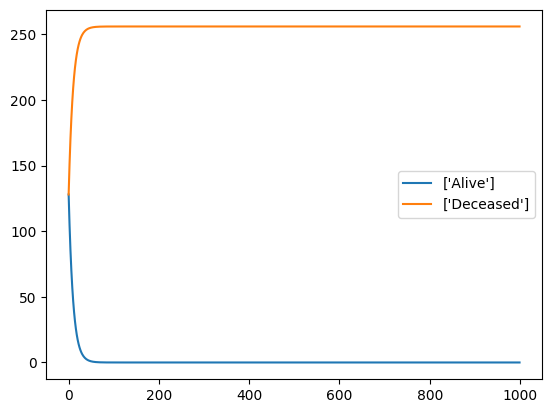

In [299]:
plot_by_labels([['Alive'], ['Deceased']])